# **K-Means Clustering: Asset Regimes Identification**

This notebook implements the K-Means algorithm as a benchmark machine learning method. It uses the 9-feature dataset prepared in the EDA phase and applies the necessary preprocessing steps to ensure the data is suitable for distance-based clustering.

The goal is to classify stocks into distinct market regimes based on both risk and fundamental metrics. By analyzing the resulting clusters, we can identify patterns such as groups of low-volatility, high-momentum large caps versus high-risk, high-variance small caps.

## **1. Imports & Data Loading**
We begin by importing the necessary libraries and loading our raw dataset containing the 9 engineered features for the S&P 1500 universe (S&P 500, 400, and 600).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [3]:
# Load the dataset
file_path = '/Users/martin/Desktop/Centrale/3A/Projet Data/raw_dataset.csv'
df_raw = pd.read_csv(file_path, index_col=0) 

print(f"Dataset shape: {df_raw.shape}")
df_raw.head()

Dataset shape: (1212, 9)


,volatility,momentum_12_1,max_drawdown,skewness,kurtosis,pe_ratio,roe,market_cap,beta
ticker,,,,,,,,,
A,0.293022,-0.035362,-0.360411,0.031739,2.847104,26.892778,0.206190,34842013696,1.298
AAPL,0.267779,0.189756,-0.296203,0.022923,2.482728,33.448800,1.520210,3888777003008,1.107
ABBV,0.226676,0.173003,-0.219154,-1.733872,14.289002,95.258480,11.066669,397325729792,0.334
ABNB,0.451888,-0.055079,-0.534007,-0.524063,3.349974,31.734490,0.302330,76671844352,1.139
ABT,0.213455,0.080596,-0.247474,0.084297,2.954092,30.083109,0.131580,195296903168,0.751


## **2. Data Preprocessing**

As identified during the Exploratory Data Analysis (EDA), K-Means clustering relies on Euclidean distance. Therefore, it is highly sensitive to outliers and unscaled features. We must apply a three-step preprocessing pipeline before running the algorithm.

### **Step 2.1: Log Transformation**
The `market_cap` feature exhibits a severe right skew due to mega-cap stocks. We apply a logarithmic transformation to compress this extreme right tail and make the distribution more symmetrical.

In [4]:
df_clean = df_raw.copy()

# Apply log transformation to market capitalization
df_clean['market_cap'] = np.log(df_clean['market_cap'])

# Rename the column for clarity
df_clean.rename(columns={'market_cap': 'log_market_cap'}, inplace=True)

### **Step 2.2: Winsorization (Outlier Clipping)**
Features such as `pe_ratio`, `roe`, `skewness`, and `kurtosis` contain extreme statistical outliers that reflect specific market events or accounting anomalies. 

Instead of dropping these rows (which would create a survivorship bias), we cap the extreme **1%** tails. Values below the 1st percentile or above the 99th percentile are replaced by those exact percentile values.

In [5]:
features_to_clip = ['pe_ratio', 'roe', 'skewness', 'kurtosis']

for col in features_to_clip:
    lower_bound = df_clean[col].quantile(0.01)
    upper_bound = df_clean[col].quantile(0.99)
    df_clean[col] = df_clean[col].clip(lower=lower_bound, upper=upper_bound)

### **Step 2.3: Standardization**
Finally, we must scale all features so they carry equal weight in the K-Means distance calculation. We use standard Z-Score normalization, transforming each feature to have a mean of 0 and a standard deviation of 1:

$z=\frac{x-\mu}{\sigma}$

In [6]:
scaler = StandardScaler()

# Fit and transform the clean data
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_clean), 
    columns=df_clean.columns, 
    index=df_clean.index
)

# Display the final preprocessed dataset ready for clustering
display(df_scaled.describe().round(3))
df_scaled.head()

,volatility,momentum_12_1,max_drawdown,skewness,kurtosis,pe_ratio,roe,log_market_cap,beta
count,1212.000,1212.000,1212.000,1212.000,1212.000,1212.000,1212.000,1212.000,1212.000
mean,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-1.662,-4.439,-4.023,-4.807,-0.681,-0.607,-0.799,-2.175,-2.705
25%,-0.694,-0.531,-0.584,-0.279,-0.527,-0.426,-0.476,-0.713,-0.642
50%,-0.216,0.069,0.229,0.130,-0.326,-0.255,-0.288,-0.140,-0.047
75%,0.447,0.555,0.765,0.498,0.081,-0.010,0.072,0.596,0.561
max,8.131,5.912,1.669,2.091,5.645,6.869,5.994,3.936,10.039


,volatility,momentum_12_1,max_drawdown,skewness,kurtosis,pe_ratio,roe,log_market_cap,beta
ticker,,,,,,,,,
A,-0.483298,-0.585037,0.177556,0.291317,-0.508040,-0.191720,0.021194,0.776259,0.616926
AAPL,-0.694017,0.164785,0.618574,0.281834,-0.540719,-0.057324,5.355352,3.824738,0.191397
ABBV,-1.037114,0.108986,1.147783,-1.607784,0.518134,1.209752,5.993594,2.349908,-1.530769
ABNB,0.842821,-0.650710,-1.014797,-0.306506,-0.462940,-0.092466,0.411467,1.286197,0.262690
ABT,-1.147477,-0.198803,0.953269,0.347849,-0.498444,-0.126319,-0.281679,1.890708,-0.601735


## **3. Determining the Optimal Number of Clusters ($k$)**

K-Means requires the number of clusters $k$ to be specified in advance. To find the optimal $k$ that captures the underlying market structure without overfitting, we evaluate two standard metrics across a range of possible $k$ values (from 2 to 10):

1. **Inertia (Elbow Method):** Measures the within-cluster sum of squares (WCSS). We look for an "elbow" point where the rate of variance reduction slows down significantly.
2. **Silhouette Score:** Measures how similar an object is to its own cluster compared to other clusters. Values range from -1 to 1, with higher values indicating dense, well-separated clusters.

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# We test k values from 2 to 10
k_range = range(2, 11)
inertia = []
silhouette_scores = []

# Using a random state for reproducibility 
# n_init=10 is explicitly set to avoid future warnings and ensure stability
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(df_scaled)
    
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_scaled, cluster_labels))

### **3.1 Visualizing the Metrics**
We plot both the Elbow curve and the Silhouette scores to visually determine the best trade-off for our equity portfolio context.

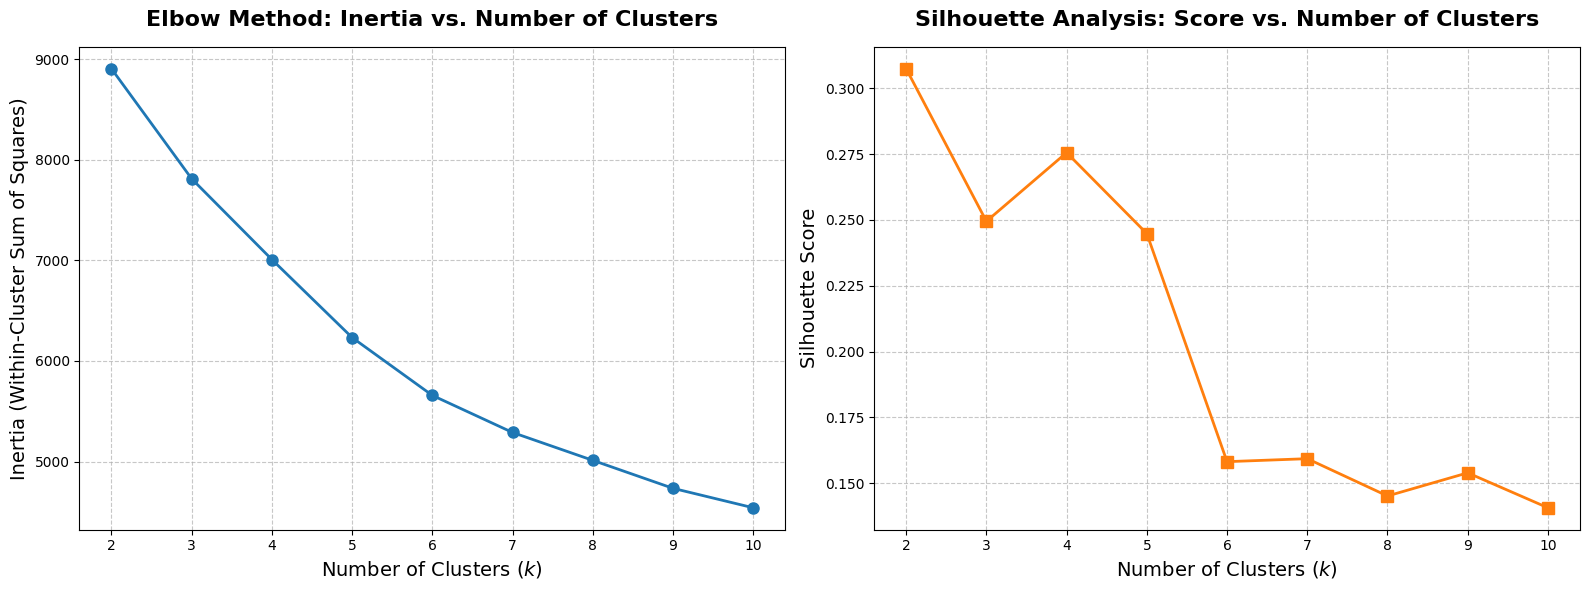

In [8]:
# Create a figure with two subplots side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Elbow Method (Inertia)
ax1.plot(k_range, inertia, marker='o', linestyle='-', color='#1f77b4', linewidth=2, markersize=8)
ax1.set_title('Elbow Method: Inertia vs. Number of Clusters', fontsize=16, fontweight='bold', pad=15)
ax1.set_xlabel('Number of Clusters ($k$)', fontsize=14)
ax1.set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=14)
ax1.set_xticks(k_range)
ax1.grid(True, linestyle='--', alpha=0.7)

# Plot 2: Silhouette Score
ax2.plot(k_range, silhouette_scores, marker='s', linestyle='-', color='#ff7f0e', linewidth=2, markersize=8)
ax2.set_title('Silhouette Analysis: Score vs. Number of Clusters', fontsize=16, fontweight='bold', pad=15)
ax2.set_xlabel('Number of Clusters ($k$)', fontsize=14)
ax2.set_ylabel('Silhouette Score', fontsize=14)
ax2.set_xticks(k_range)
ax2.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### **3.2. Conclusion on the Optimal $k$**
Based on the graphs above:
* The **Silhouette Score** suggests $k=2$ yields the highest mathematical separation. However, dividing the entire US stock market into only two regimes is too binary for portfolio construction. 
* Looking further, there is a strong local maximum at **$k=4$** (score $\approx$ 0.275). Beyond $k=5$, the silhouette score drops sharply.
* The **Elbow Curve** shows a steady decline, with the variance reduction rate beginning to slow down around $k=4$ to $k=6$.

**Decision:** We select **$k=4$** as the optimal number of clusters. It provides a strong mathematical fit while offering enough granularity to define actionable financial regimes (e.g., Defensive, Growth, Value, Speculative).

## **4. Final K-Means Model & Cluster Profiling**
Now, we run the K-Means algorithm with $k=4$ and attach the resulting labels back to our unscaled data to interpret the actual financial metrics (real Volatility, real P/E ratios, etc.) of each cluster.

In [9]:
# Train the final K-Means model
optimal_k = 4
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(df_scaled)

# Attach the labels to our RAW dataframe for pure financial interpretation
# (We use df_raw so we can see the actual Market Cap in billions, not the log version)
df_raw['Cluster'] = cluster_labels

# Check the distribution of stocks across our 4 clusters
cluster_counts = df_raw['Cluster'].value_counts().sort_index()
print("Number of stocks per cluster:")
print(cluster_counts)

Number of stocks per cluster:
Cluster
0     46
1    287
2    820
3     59
Name: count, dtype: int64


### **4.1. Financial Profiling of the Clusters**
To understand the "personality" of each cluster, we compute the median values of our features for each group. We use the median rather than the mean to prevent the remaining extreme outliers (like mega-cap sizes or infinite P/E ratios) from skewing the interpretation.

In [13]:
# Group by cluster and calculate the median for each feature
cluster_profile = df_raw.groupby('Cluster').median()

# Reorder columns to group them logically (Risk, Fundamentals, Moments)
cols_order = ['volatility', 'max_drawdown', 'beta', 'momentum_12_1', 
              'pe_ratio', 'roe', 'market_cap', 
              'skewness', 'kurtosis']
cluster_profile = cluster_profile[cols_order]

# Create a heatmap-styled dataframe for easier reading in the notebook
def style_negative_positive(val):
    color = '#d65f5f' if val < 0 else '#5fba7d'
    return f'color: {color}'

# Apply pandas background gradient to highlight high/low values per column
styled_profile = cluster_profile.style.background_gradient(cmap='Blues', axis=0) \
    .format(precision=2) \
    .format({'market_cap': "{:,.0f}"}) # Format market cap nicely

styled_profile

,volatility,max_drawdown,beta,momentum_12_1,pe_ratio,roe,market_cap,skewness,kurtosis
Cluster,,,,,,,,,
0,0.293846,-0.301128,1.032000,0.196189,24.656205,1.180770,"30,842,078,208",-0.002388,5.763040
1,0.452299,-0.537882,1.358000,0.011394,30.220657,0.106020,"4,947,721,216",-0.095922,5.984142
2,0.294811,-0.311563,0.888000,0.198064,22.331587,0.131775,"10,237,380,096",-0.091304,4.295704
3,0.466046,-0.573071,0.900000,-0.194587,25.427220,0.128600,"5,776,176,128",-2.847336,41.507627


### **4.2. Cluster Interpretation for the Insurer Mandate**

Based on the median feature profiles, our K-Means algorithm successfully segmented the S&P 1500 universe into four distinct market regimes:

* **Cluster 0 - Quality Large-Caps:** Massive market capitalizations, stable volatility, and strong profitability (high ROE). These are the market leaders.
* **Cluster 1 - High-Beta Speculative:** Smaller companies with high volatility, massive market sensitivity (Beta = 1.35), and steep valuations. High risk, high reward.
* **Cluster 2 - Defensive Value:** The ideal cluster for our **Life Insurance Client**. It boasts the lowest market sensitivity (Beta = 0.88), minimal historical drawdowns, reasonable valuations, and solid momentum. 
* **Cluster 3 - Tail-Risk / Distressed:** Assets characterized by negative momentum, extreme negative skewness, and massive kurtosis (crash risk). These must be strictly avoided given the client's low-risk tolerance.

Let's visualize these regimes to confirm the mathematical separation intuitively.

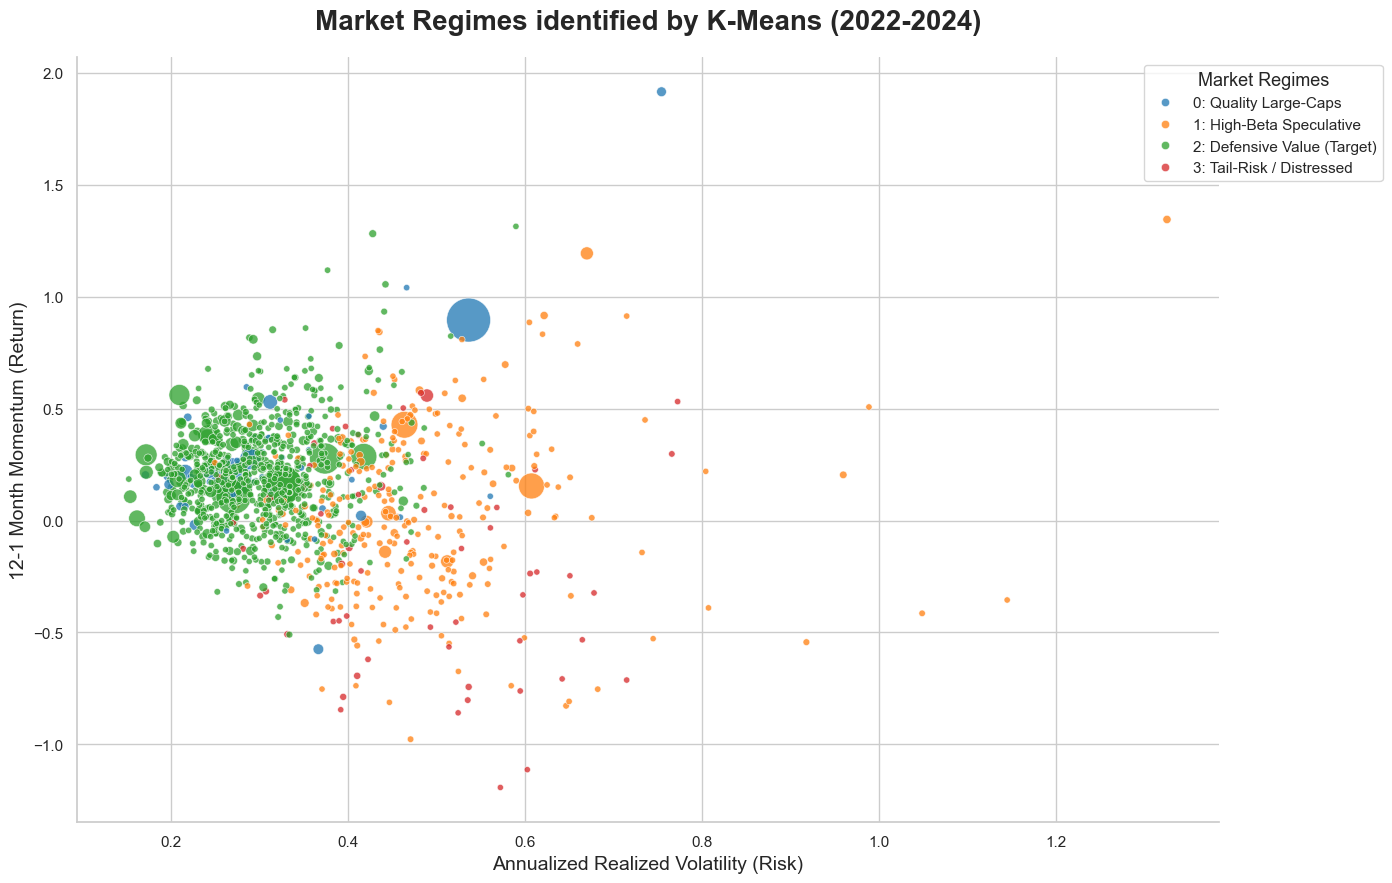

In [14]:
# Set up the plot aesthetics
plt.figure(figsize=(14, 9))
sns.set_theme(style="whitegrid", rc={"axes.spines.right": False, "axes.spines.top": False})

# Define a custom color palette for financial intuition
# 0: Blue (Quality), 1: Orange (Speculative), 2: Green (Defensive/Target), 3: Red (Distressed)
cluster_colors = {0: '#1f77b4', 1: '#ff7f0e', 2: '#2ca02c', 3: '#d62728'}
cluster_labels_text = {
    0: '0: Quality Large-Caps', 
    1: '1: High-Beta Speculative', 
    2: '2: Defensive Value (Target)', 
    3: '3: Tail-Risk / Distressed'
}

# Create the scatter plot
scatter = sns.scatterplot(
    data=df_raw, 
    x='volatility', 
    y='momentum_12_1', 
    hue='Cluster', 
    palette=cluster_colors,
    size='market_cap', 
    sizes=(20, 1000), # Bubble size range
    alpha=0.75, 
    edgecolor='white',
    linewidth=0.5
)

# Customize titles and labels
plt.title('Market Regimes identified by K-Means (2022-2024)', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Annualized Realized Volatility (Risk)', fontsize=14, fontweight='medium')
plt.ylabel('12-1 Month Momentum (Return)', fontsize=14, fontweight='medium')

# Customize the legend
handles, labels = scatter.get_legend_handles_labels()
# Filter out the 'market_cap' size legend parts to keep it clean, only show clusters
legend_handles = [h for h, l in zip(handles, labels) if l in [str(i) for i in range(4)]]
plt.legend(
    legend_handles, 
    [cluster_labels_text[i] for i in range(4)], 
    title='Market Regimes', 
    title_fontsize='13', 
    fontsize='11', 
    loc='upper right', 
    bbox_to_anchor=(1.15, 1)
)

plt.tight_layout()
plt.show()

## **5. Conclusion & Next Steps**

The K-Means baseline fulfilled its primary objective: dimension reduction and universe filtering. By isolating **Cluster 2 (Defensive Value)**, we effectively discard distressed assets, speculative high-beta stocks, and unnecessary tail risks. 

We have successfully narrowed down the broad S&P 1500 universe into a highly liquid, low-volatility, and stable subset of equities that natively aligns with the strict requirements of a US Life Insurance company.

**Next Step:** We will now take the constituents of **Cluster 2** and apply advanced portfolio construction techniques. We will explore **Hierarchical Risk Parity (HRP)** to map nested correlations and a **Genetic Algorithm** to optimize the exact capital allocation weights, aiming to maximize returns while strictly capping downside risk.